<a href="https://colab.research.google.com/github/LiYuan199701/AMIC/blob/Time-impact-Wine-Review/sentiment_rating_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sentiment-Rating linear mixed model up to 2024

## Load packages

In [ ]:
import pyximport
import os
import IPython
import Cython
import sys
import os
import numpy as np
import pandas as pd
import copy
import scipy
import pickle
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import random, math, sys, string, re
import statsmodels.formula.api as smf
%matplotlib inline
# Set inline backend and resolution
%config InlineBackend.figure_format = 'retina'  # For Retina displays
plt.rcParams['figure.dpi'] = 100  # Set dpi to 200 for high resolution

## Mount Google Driver, Read in Data Set from my Google Driver

In [ ]:
%%time
# Mount Google Driver
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Change to my project directory
os.chdir('/content/drive/MyDrive/AMIC project')

# Read in wine sentiment-rating data
df = pd.read_csv('./data/new_data_with_review_year.csv', index_col=0)

# Randomly select 2000 rows from df
#df = df.sample(n=2000, random_state=42)

print("DF Shape:", df.shape)
df.head()

Mounted at /content/drive
DF Shape: (13696, 7)
CPU times: user 1.86 s, sys: 335 ms, total: 2.2 s
Wall time: 21.3 s


,index,true_rating,predicted_rating,sentiment,rating,Clean_desc,review_year
0,13343,88.0,86.771576,0.937251,88,"Light and soft, with cherry and raspberry flav...",NV (reviewed 2019)
1,4793,92.0,92.506035,1.662355,92,This creamy Champagne has a round juiciness to...,NV (reviewed 2023)
2,13811,91.0,90.806600,1.413998,91,"Warm fruitcake, brown bread and mulled raisin ...",NV (reviewed 2017)
3,11029,90.0,90.160310,1.328816,90,"A spiced rosé, with a Lambic-like hint of mace...",NV (reviewed 2014)
4,7355,93.0,89.342350,1.226706,93,"Flattering and stylish, with baked peach, quin...",NV (reviewed 2021)


## Distribution of rating and sentiment

Text(0.5, 1.0, 'Distribution of Sentiment')

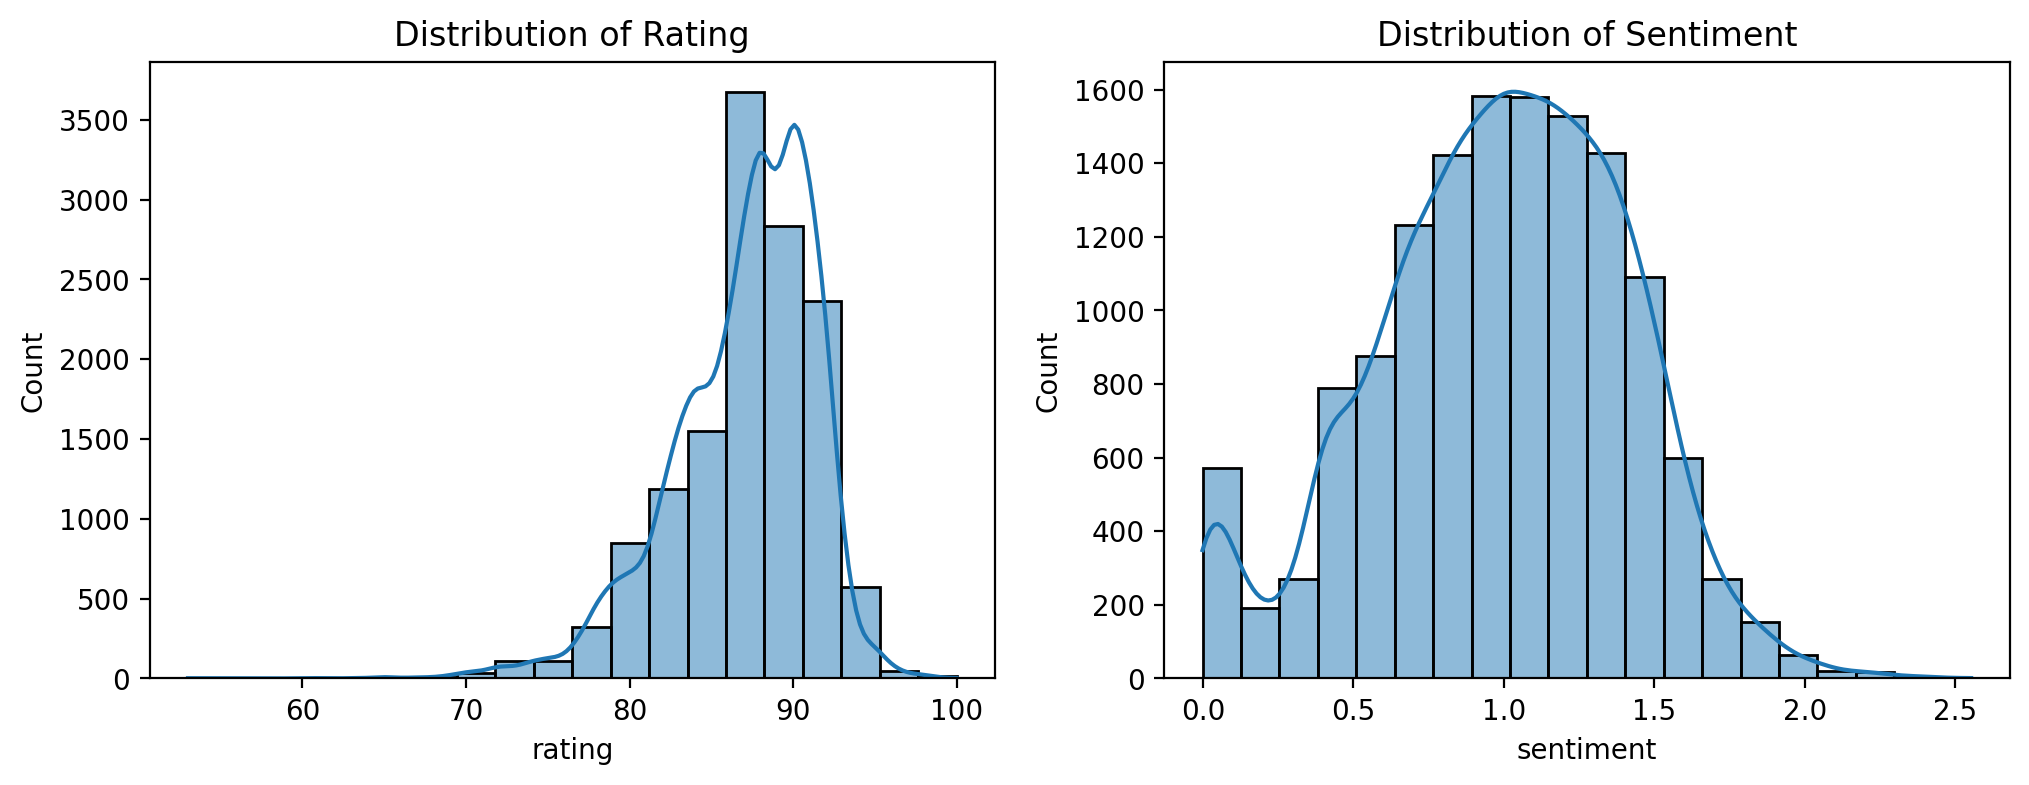

In [ ]:
# Plot the distribution plots to show ratings and sentiment
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot
sns.histplot(df['rating'], bins=20, kde=True, ax=axes[0])
sns.histplot(df['sentiment'], bins=20, kde=True, ax=axes[1])

# Set titles
axes[0].set_title('Distribution of Rating')
axes[1].set_title('Distribution of Sentiment')

## Preprocess data

In [ ]:
# check the variable type of df
df.dtypes

,0
index,int64
true_rating,float64
predicted_rating,float64
sentiment,float64
rating,int64
Clean_desc,object
review_year,object


In [ ]:
# Drop rows with missing values in the columns used by the model
# This ensures that the data passed to mixedlm has consistent rows
df_cleaned = df.dropna(subset=['rating', 'review_year', 'sentiment'])

# reset index for df_cleaned
df_cleaned = df_cleaned.reset_index(drop=True)

# Print the number of rows dropped and the new data shape
print("Number of rows dropped:", len(df) - len(df_cleaned))
print("Data Shape:", df_cleaned.shape)
df_cleaned.head()

Number of rows dropped: 0
Data Shape: (13696, 7)


,index,true_rating,predicted_rating,sentiment,rating,Clean_desc,review_year
0,13343,88.0,86.771576,0.937251,88,"Light and soft, with cherry and raspberry flav...",NV (reviewed 2019)
1,4793,92.0,92.506035,1.662355,92,This creamy Champagne has a round juiciness to...,NV (reviewed 2023)
2,13811,91.0,90.806600,1.413998,91,"Warm fruitcake, brown bread and mulled raisin ...",NV (reviewed 2017)
3,11029,90.0,90.160310,1.328816,90,"A spiced rosé, with a Lambic-like hint of mace...",NV (reviewed 2014)
4,7355,93.0,89.342350,1.226706,93,"Flattering and stylish, with baked peach, quin...",NV (reviewed 2021)


## Convert review_year into continuous variable

In [ ]:
# Extract 4-digit year from parentheses if present
df_cleaned['clean_year'] = df_cleaned['review_year'].str.extract(r'\(?reviewed.*?(\d{4})\)?')

# Fill missing extracted years with original value if it’s already a 4-digit year
df_cleaned['clean_year'] = df_cleaned['clean_year'].fillna(
    df_cleaned['review_year'].where(df_cleaned['review_year'].str.match(r'^\d{4}$'))
)

# Convert to numeric year
df_cleaned['clean_year'] = pd.to_numeric(df_cleaned['clean_year'], errors='coerce')

df_cleaned

,index,true_rating,predicted_rating,sentiment,rating,Clean_desc,review_year,clean_year
0,13343,88.0,86.771576,0.937251,88,"Light and soft, with cherry and raspberry flav...",NV (reviewed 2019),2019
1,4793,92.0,92.506035,1.662355,92,This creamy Champagne has a round juiciness to...,NV (reviewed 2023),2023
2,13811,91.0,90.806600,1.413998,91,"Warm fruitcake, brown bread and mulled raisin ...",NV (reviewed 2017),2017
3,11029,90.0,90.160310,1.328816,90,"A spiced rosé, with a Lambic-like hint of mace...",NV (reviewed 2014),2014
4,7355,93.0,89.342350,1.226706,93,"Flattering and stylish, with baked peach, quin...",NV (reviewed 2021),2021
...,...,...,...,...,...,...,...,...
13691,6108,87.0,85.436720,0.800788,87,"Soft and easygoing, with fresh apple and cream...",NV (reviewed 2013),2013
13692,403,87.0,84.875990,0.745570,87,"Light-bodied and airy, this modest version off...",NV (reviewed 2014),2014
13693,594,88.0,88.236300,1.097057,88,"Focused, this exhibits berry and honey flavors...",NV (reviewed 2005),2005
13694,329,96.0,93.845375,1.892590,96,"Marvelous. Burnished to an orange-gold color, ...",NV (reviewed 2003),2003


## Distribution of review year

<function matplotlib.pyplot.show(close=None, block=None)>

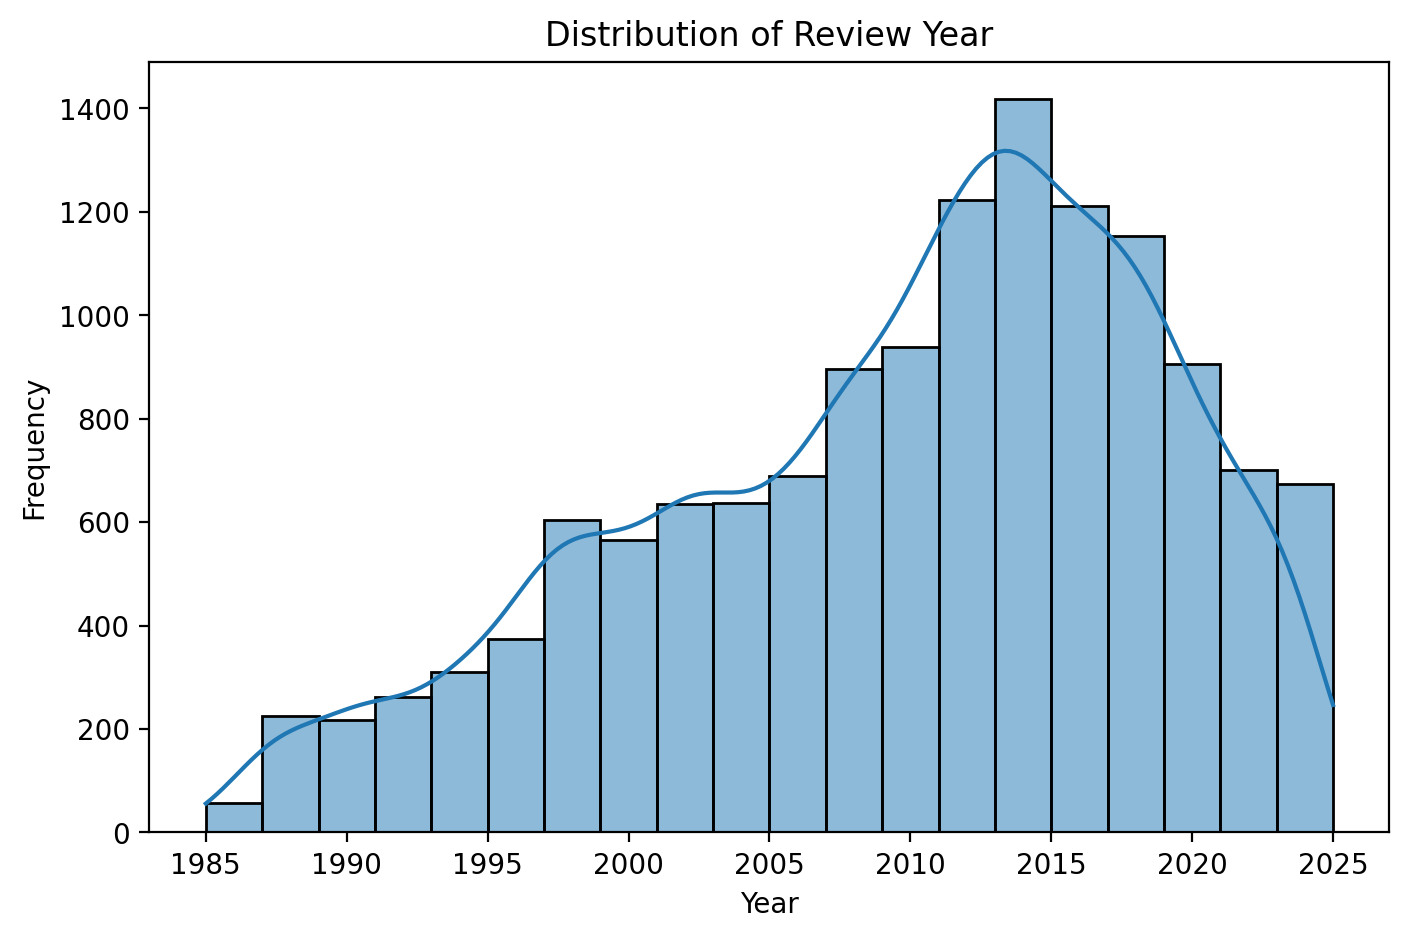

In [ ]:
# Make a plot of distribution of year
plt.figure(figsize=(8, 5))
sns.histplot(df_cleaned['clean_year'], bins=20, kde=True)
plt.title('Distribution of Review Year')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.show

## Build the rating ~ review_year + sentiment + price model

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                 2.668e+04
Date:                Tue, 12 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:40:19   Log-Likelihood:                -28748.
No. Observations:               13696   AIC:                         5.750e+04
Df Residuals:                   13693   BIC:                         5.752e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     27.3381      4.133      6.615      0.0

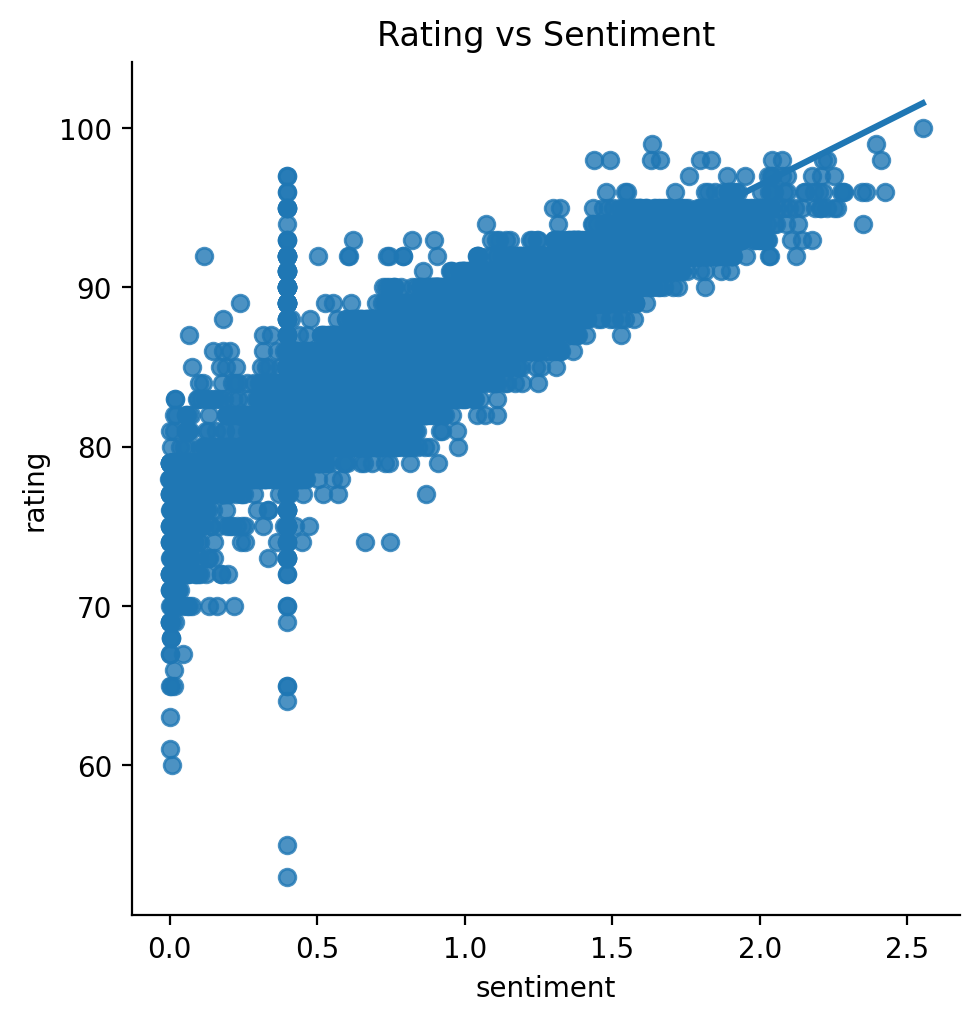

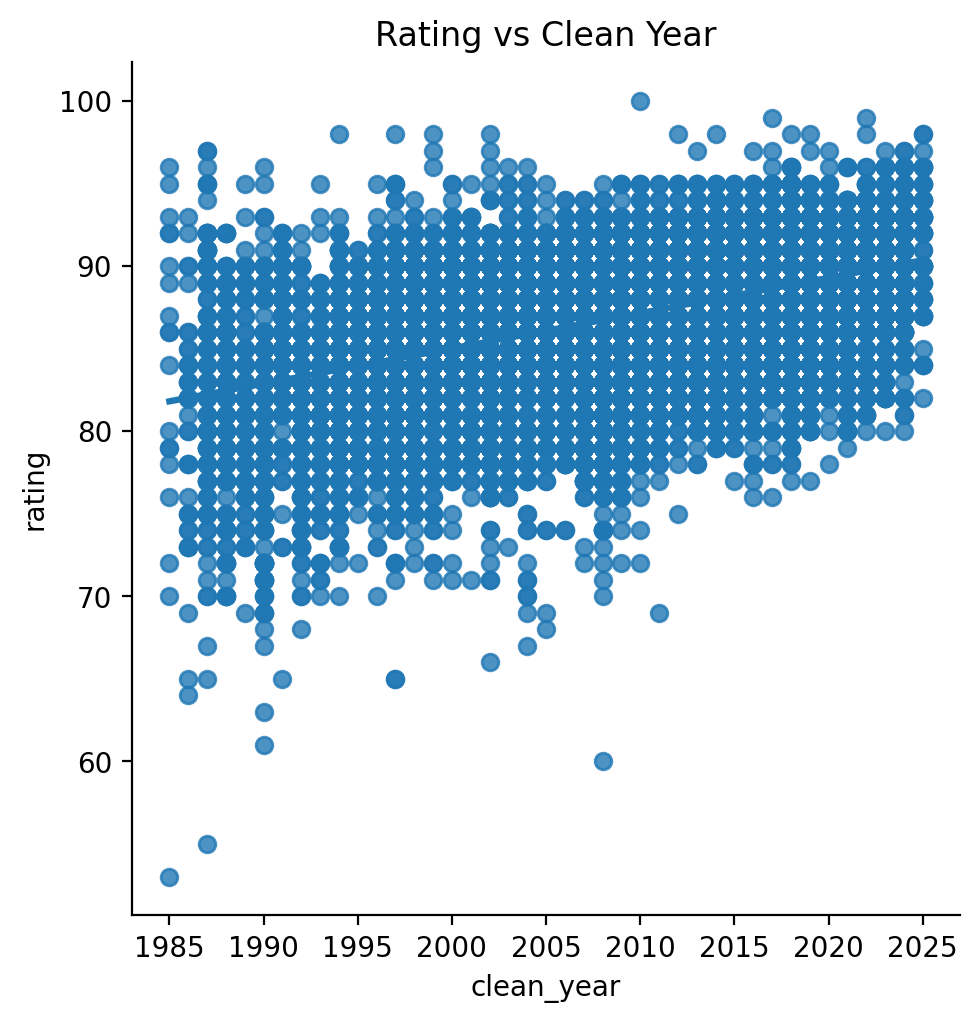

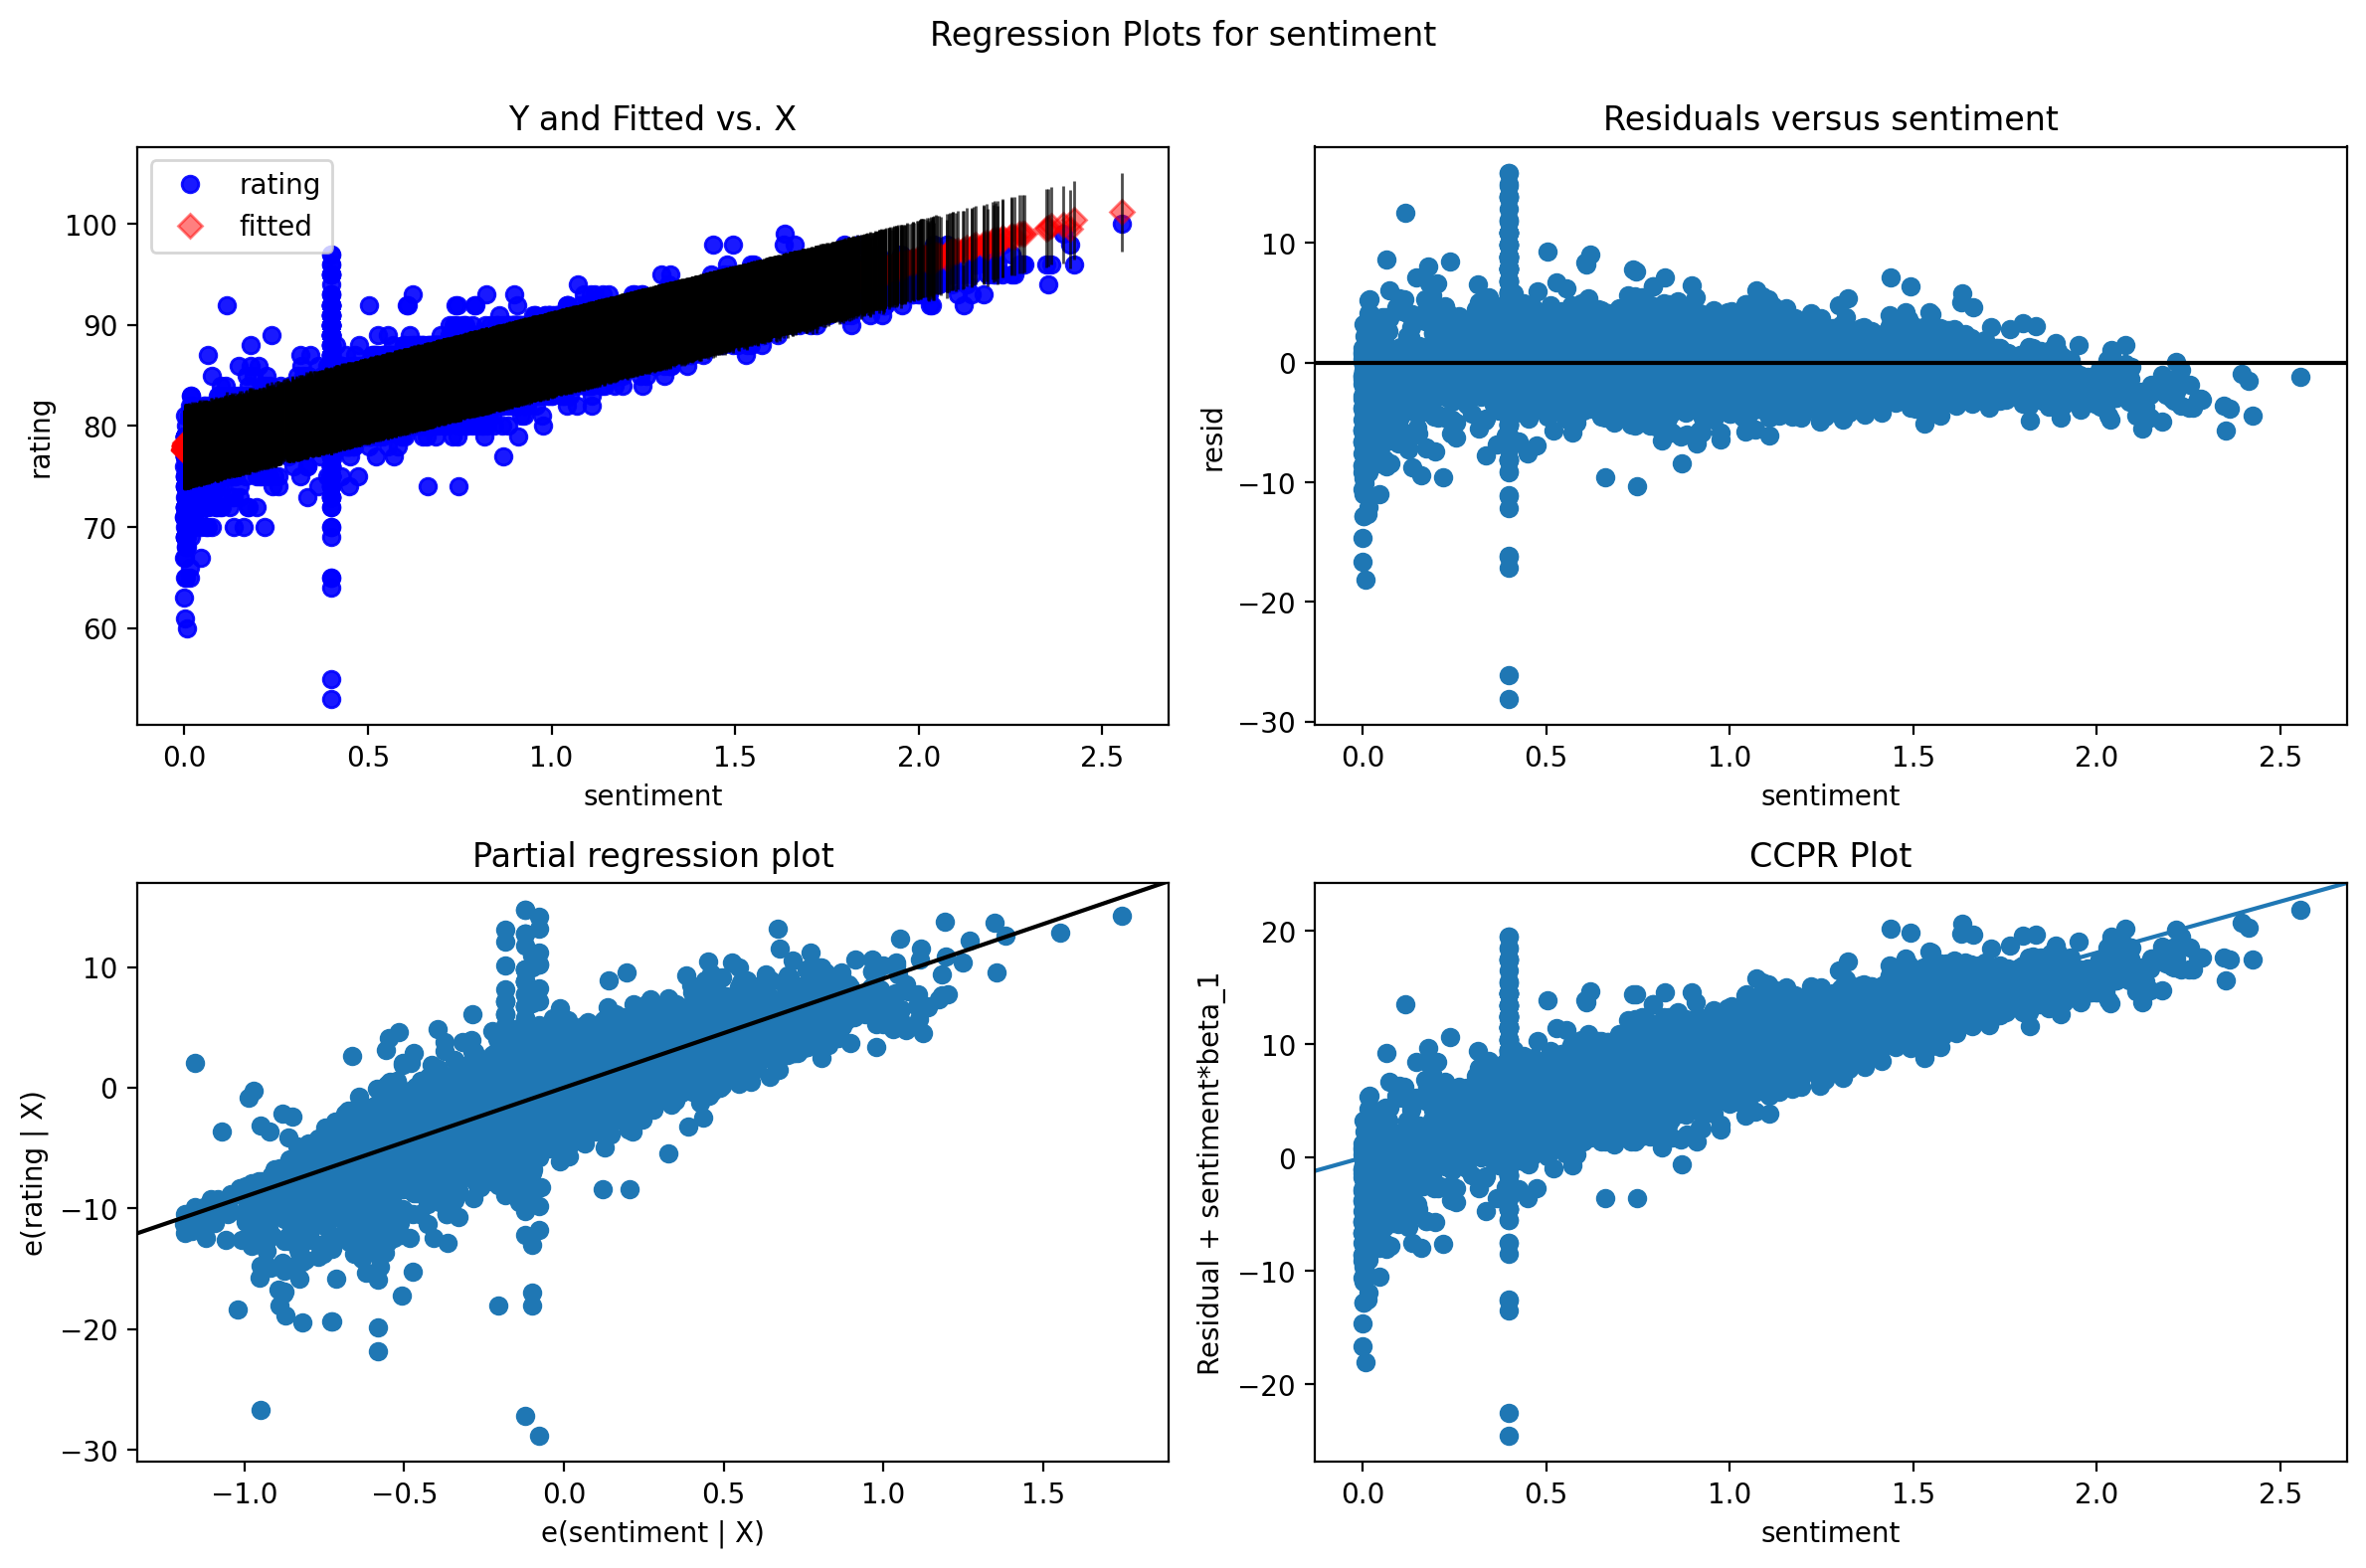

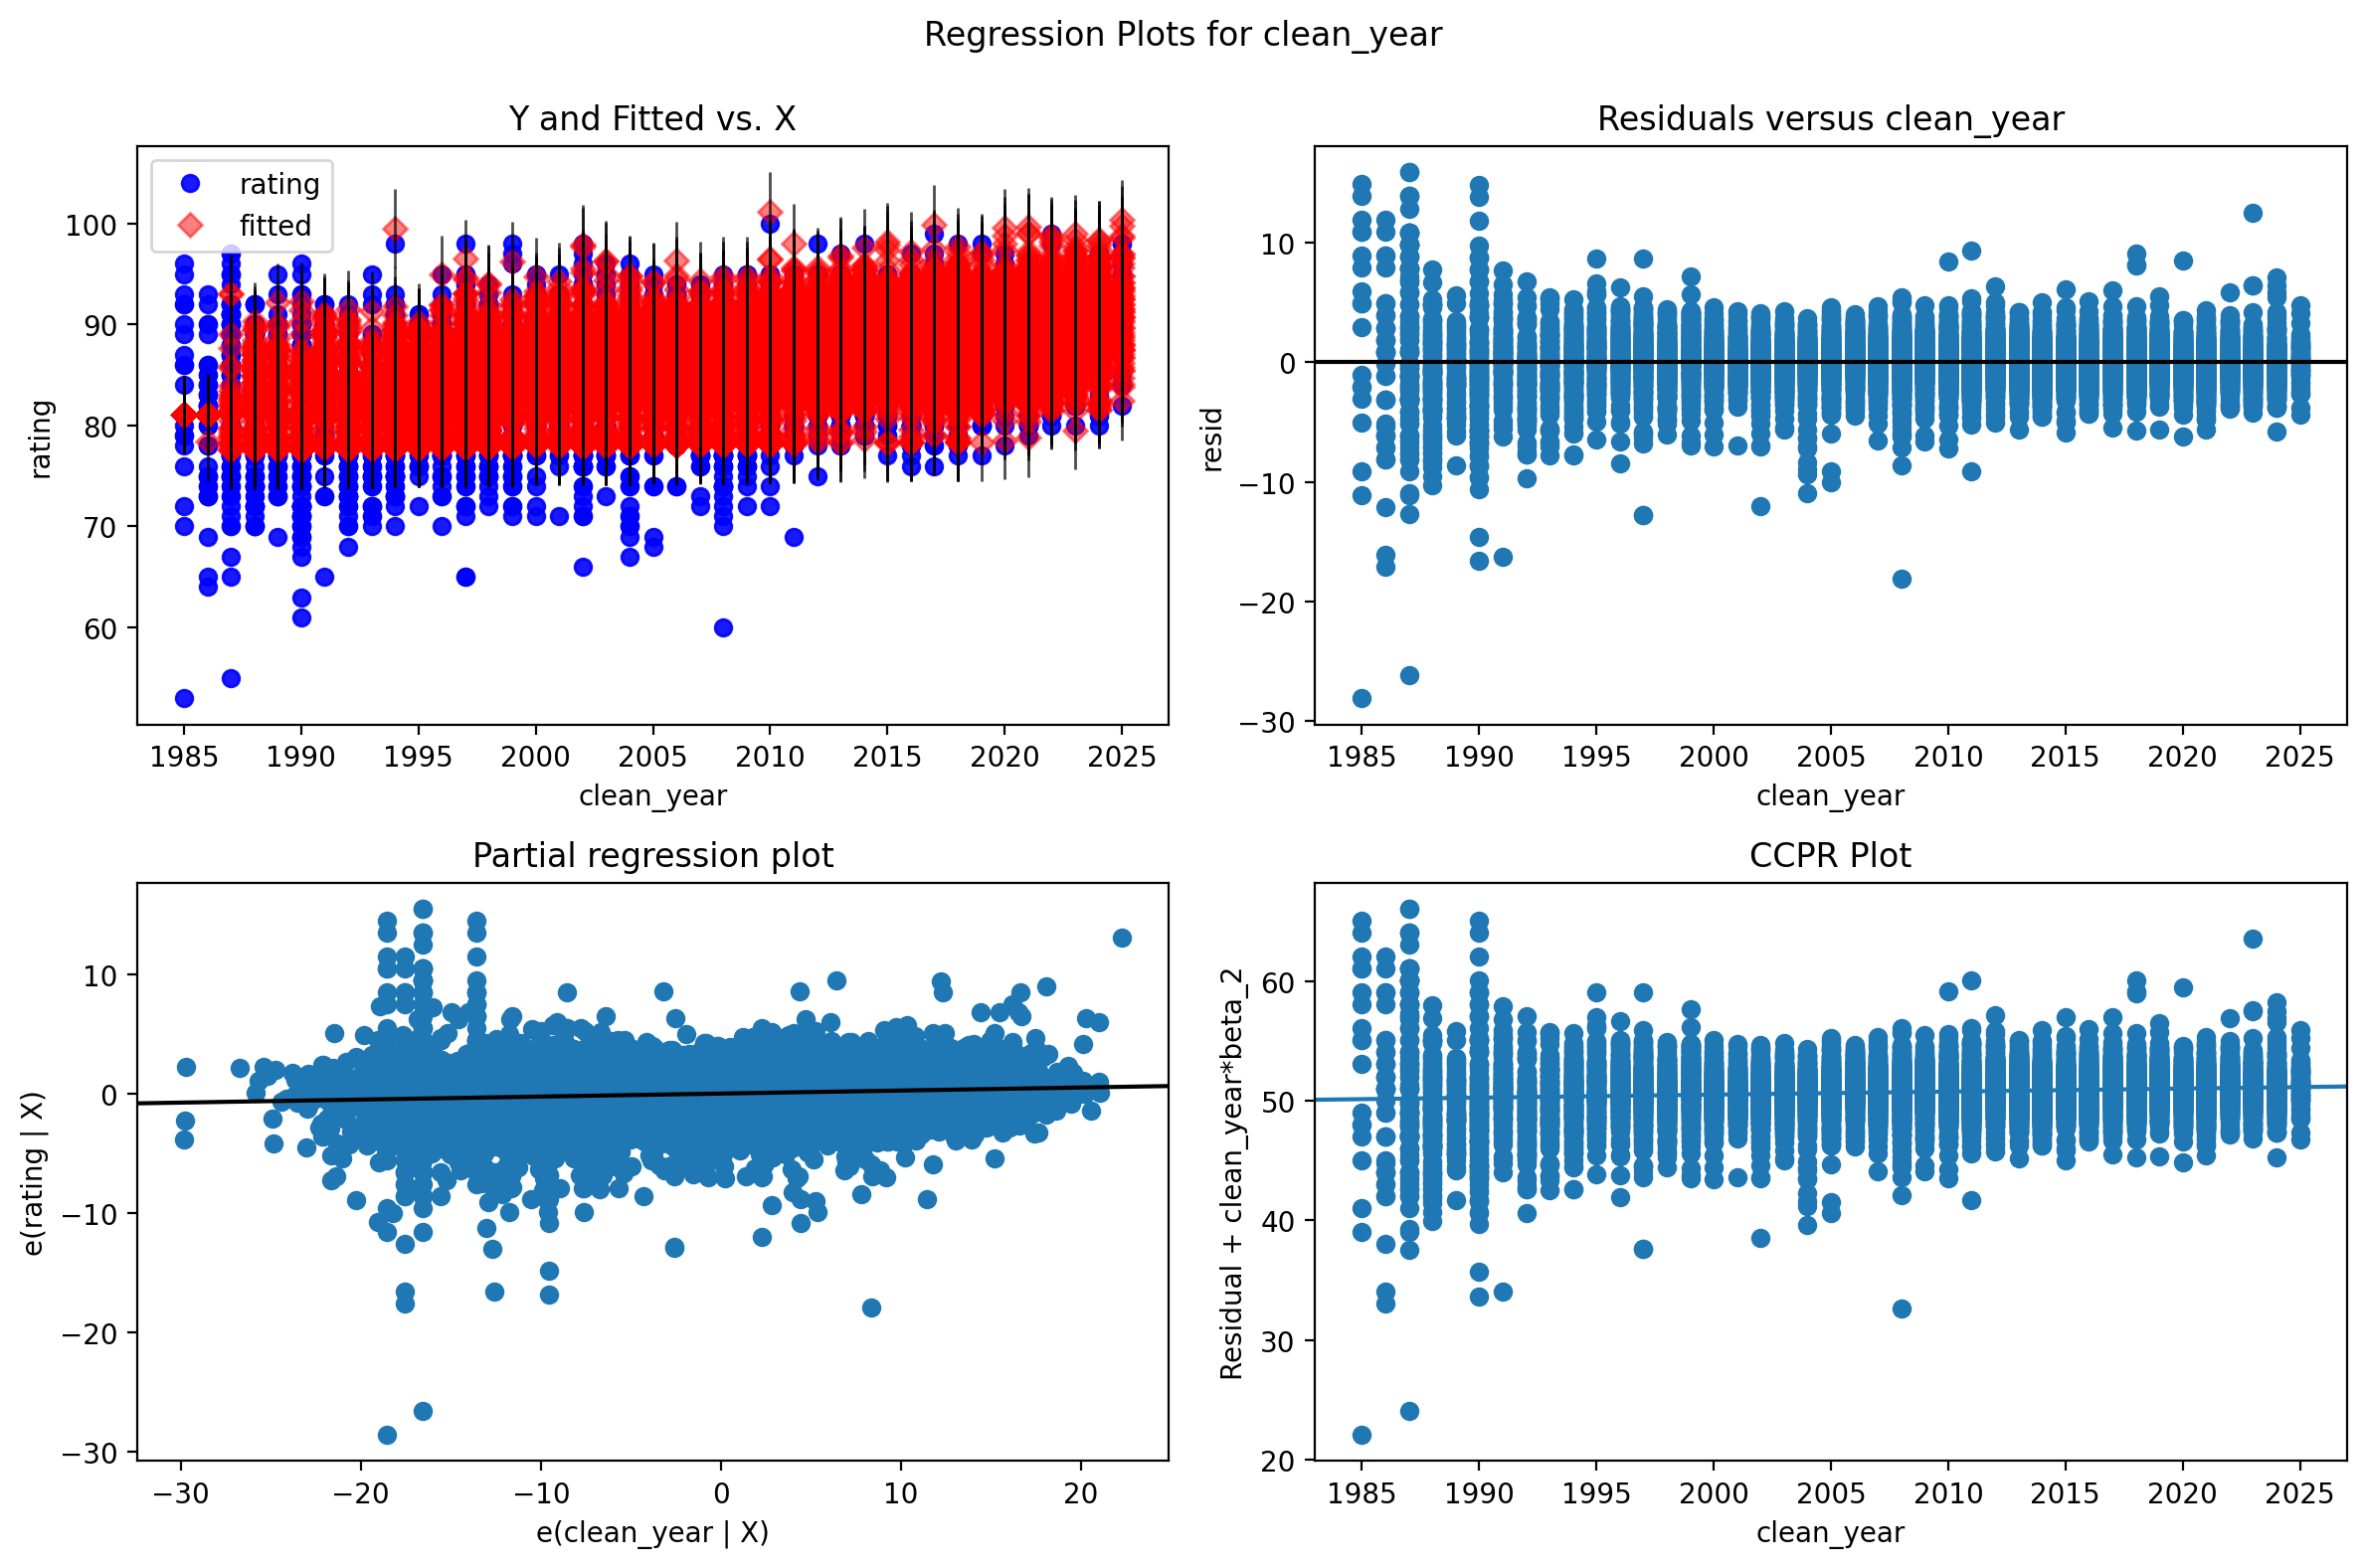

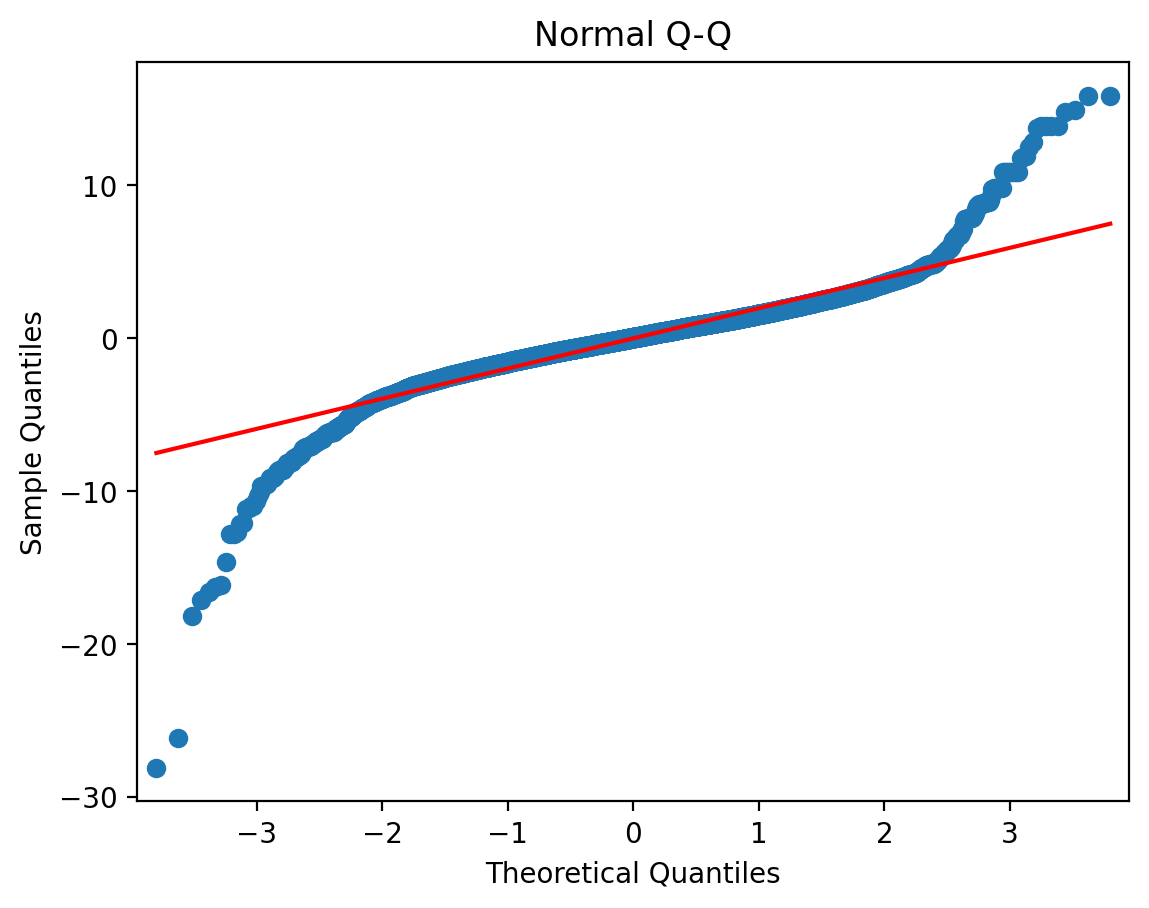

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf


# Fit linear regression model
model = smf.ols('rating ~ sentiment + clean_year', data=df_cleaned).fit()

# Print summary
print(model.summary())

# --- Visualization ---

# 1. Scatter plot: Rating vs Sentiment
sns.lmplot(x='sentiment', y='rating', data=df_cleaned)
plt.title('Rating vs Sentiment')
plt.show()

# 2. Scatter plot: Rating vs Clean Year
sns.lmplot(x='clean_year', y='rating', data=df_cleaned)
plt.title('Rating vs Clean Year')
plt.show()

# 3. Regression diagnostic plots
fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_regress_exog(model, 'sentiment', fig=fig)
plt.show()

fig = plt.figure(figsize=(12, 8))
sm.graphics.plot_regress_exog(model, 'clean_year', fig=fig)
plt.show()
'''
# 4. Residuals vs Fitted
fig = plt.figure(figsize=(8, 6))
sns.residplot(x=model.fittedvalues, y=model.resid, lowess=True)
plt.xlabel('Fitted values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted')
plt.show()
'''
# 5. Q-Q plot for residuals
sm.qqplot(model.resid, line='s')
plt.title('Normal Q-Q')
plt.show()


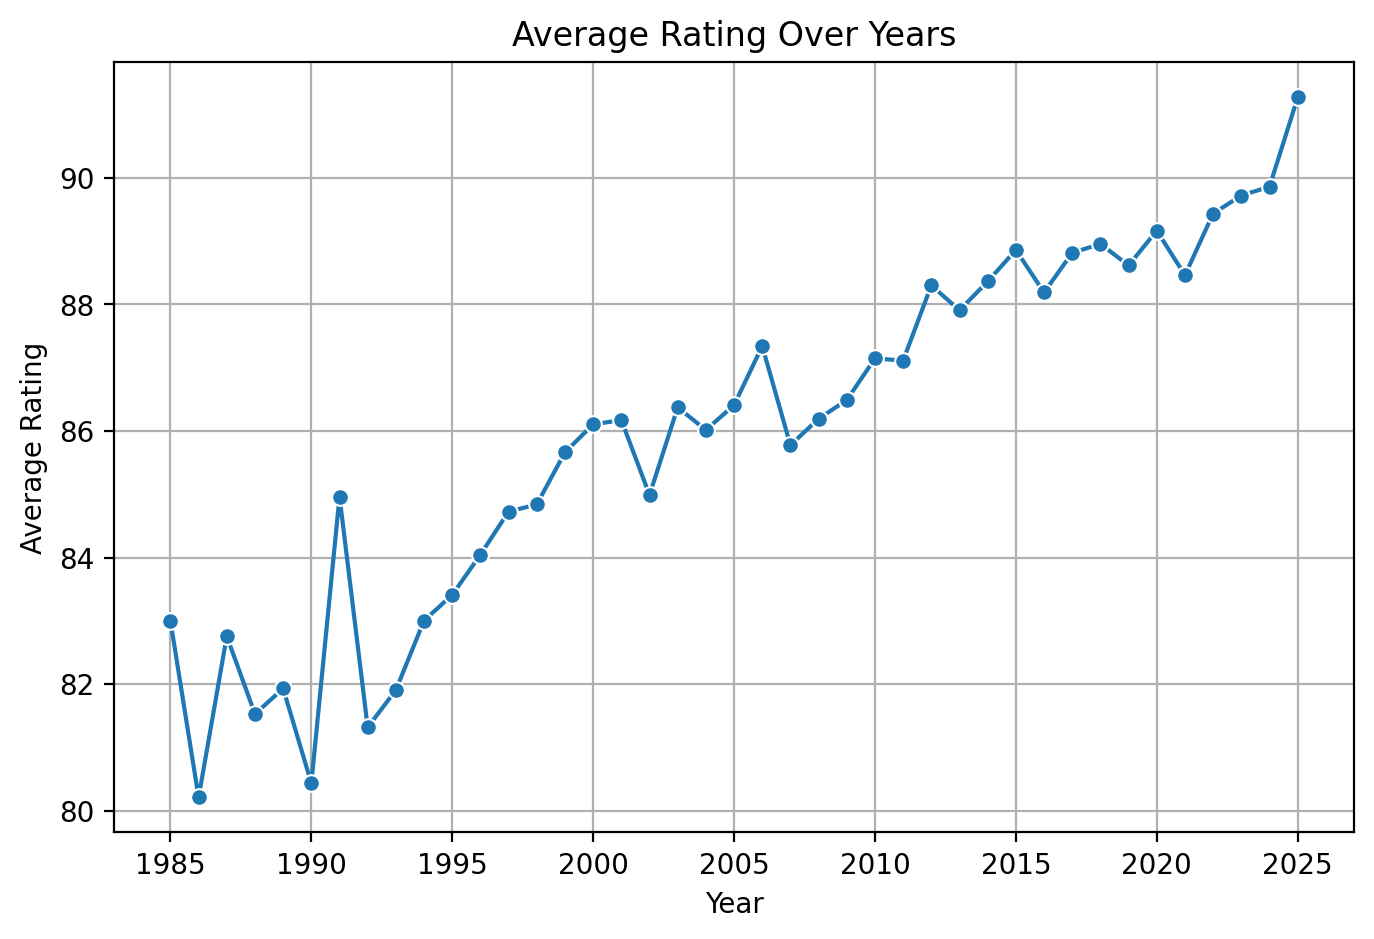

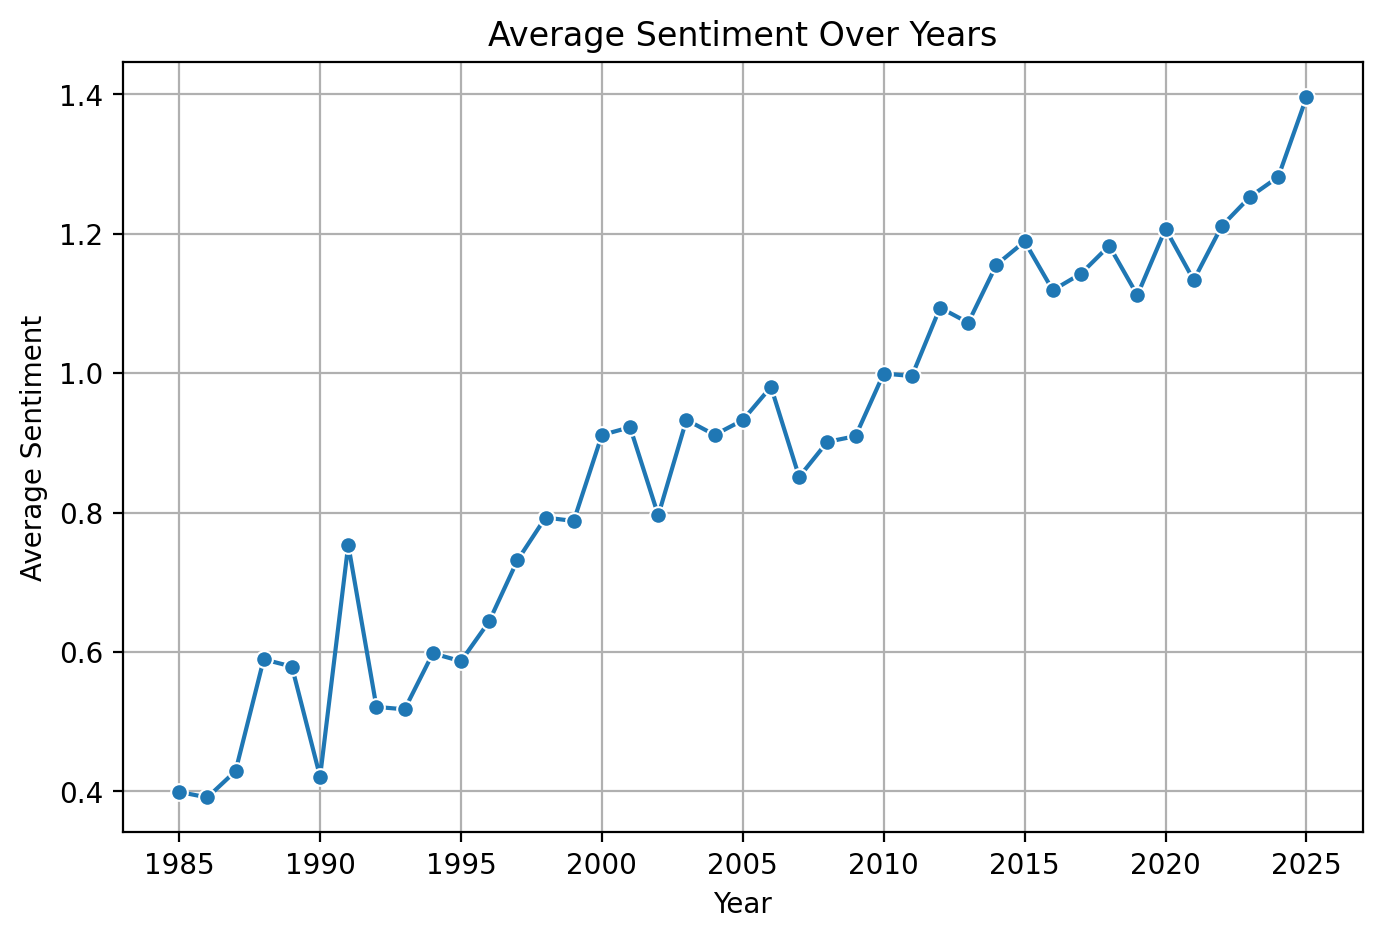

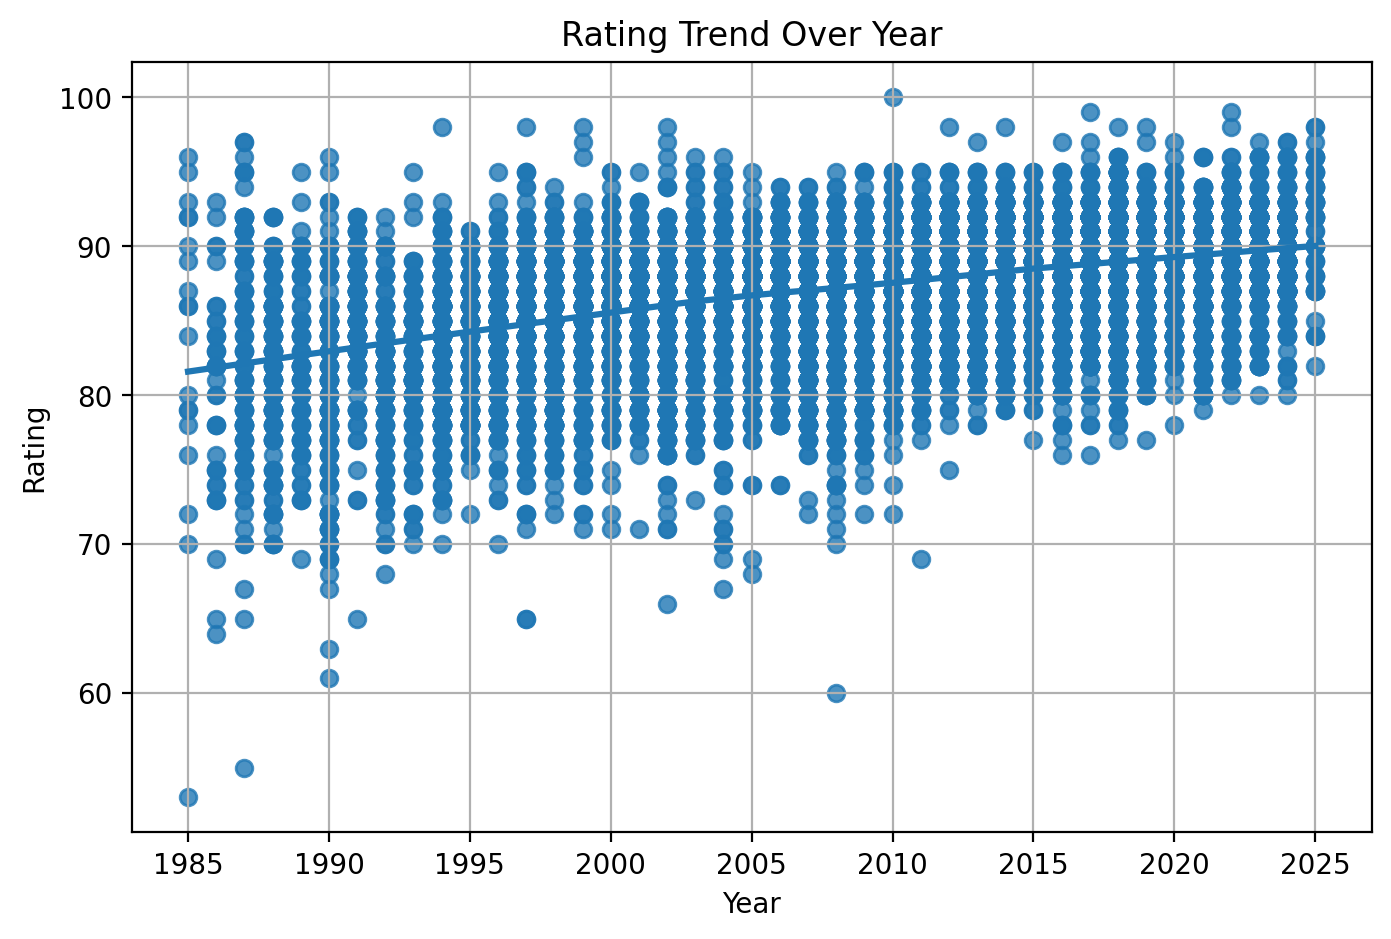

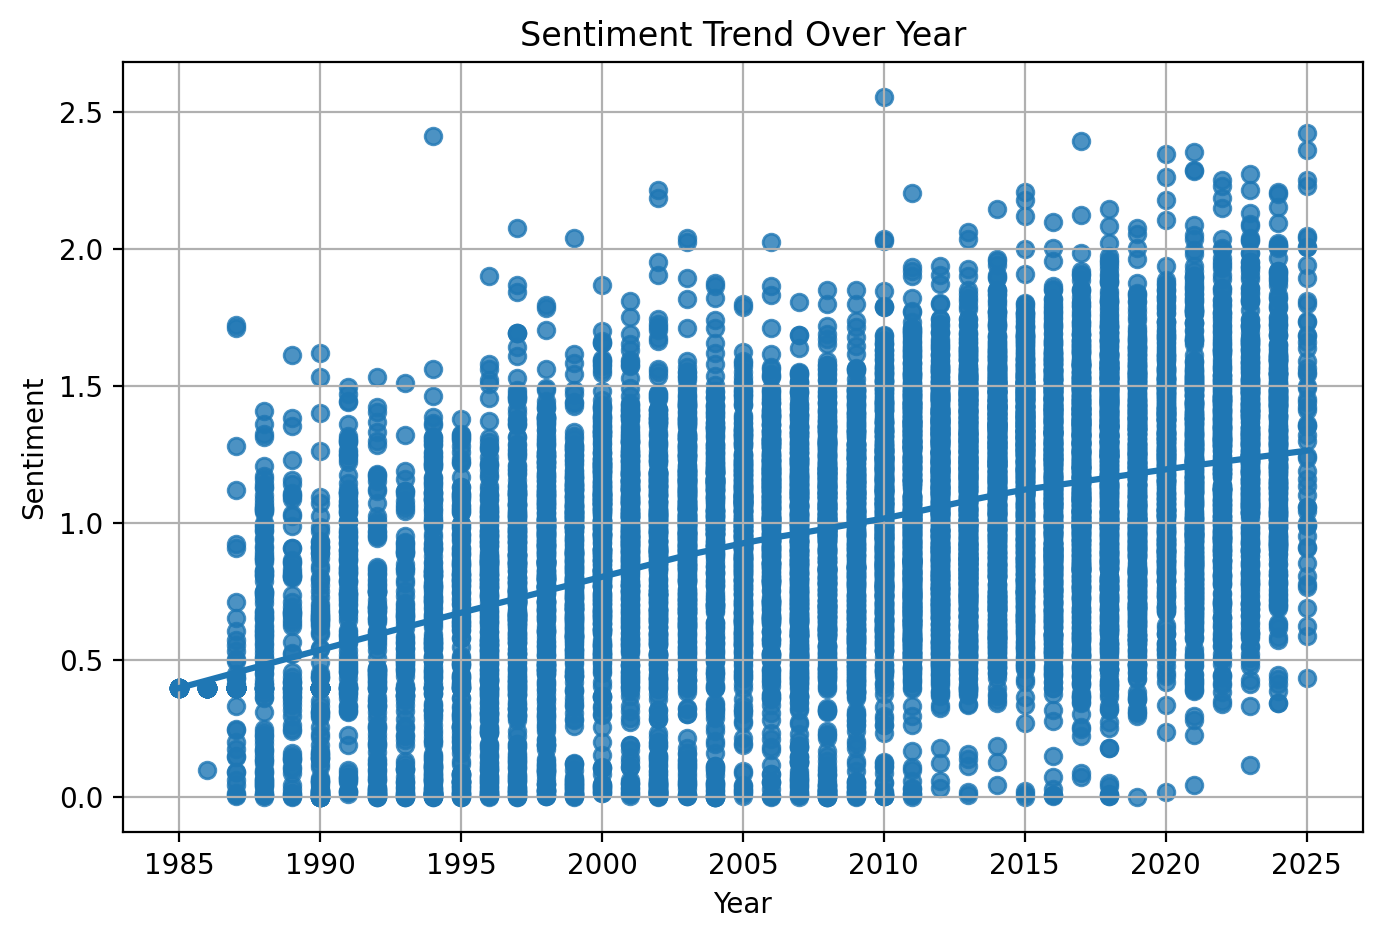

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Line plot of average rating over clean_year
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_cleaned.groupby('clean_year')['rating'].mean().reset_index(),
             x='clean_year', y='rating', marker='o')
plt.title('Average Rating Over Years')
plt.xlabel('Year')
plt.ylabel('Average Rating')
plt.grid(True)
plt.show()

# 2. Line plot of average sentiment over clean_year
plt.figure(figsize=(8, 5))
sns.lineplot(data=df_cleaned.groupby('clean_year')['sentiment'].mean().reset_index(),
             x='clean_year', y='sentiment', marker='o')
plt.title('Average Sentiment Over Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment')
plt.grid(True)
plt.show()

# 3. Scatter plot with trend line: Rating vs Year
plt.figure(figsize=(8, 5))
sns.regplot(data=df_cleaned, x='clean_year', y='rating', scatter=True, lowess=True)
plt.title('Rating Trend Over Year')
plt.xlabel('Year')
plt.ylabel('Rating')
plt.grid(True)
plt.show()

# 4. Scatter plot with trend line: Sentiment vs Year
plt.figure(figsize=(8, 5))
sns.regplot(data=df_cleaned, x='clean_year', y='sentiment', scatter=True, lowess=True)
plt.title('Sentiment Trend Over Year')
plt.xlabel('Year')
plt.ylabel('Sentiment')
plt.grid(True)
plt.show()

## Fit the Model with review_year * sentiment Interaction

In [ ]:
# Step 1: Create year_indicator
df_cleaned["year_indicator"] = (df_cleaned["clean_year"] > 2010).astype(int)
df_cleaned.head()

,index,true_rating,predicted_rating,sentiment,rating,Clean_desc,review_year,clean_year,year_indicator
0,13343,88.0,86.771576,0.937251,88,"Light and soft, with cherry and raspberry flav...",NV (reviewed 2019),2019,1
1,4793,92.0,92.506035,1.662355,92,This creamy Champagne has a round juiciness to...,NV (reviewed 2023),2023,1
2,13811,91.0,90.806600,1.413998,91,"Warm fruitcake, brown bread and mulled raisin ...",NV (reviewed 2017),2017,1
3,11029,90.0,90.160310,1.328816,90,"A spiced rosé, with a Lambic-like hint of mace...",NV (reviewed 2014),2014,1
4,7355,93.0,89.342350,1.226706,93,"Flattering and stylish, with baked peach, quin...",NV (reviewed 2021),2021,1


In [ ]:
import statsmodels.formula.api as smf

model = smf.ols(
    "rating ~ year_indicator * sentiment",
    data=df_cleaned
)
result = model.fit()

# Predict and clip between 80 and 100
# Ensure the output of predict is a pandas Series before clipping
predicted_series = pd.Series(result.predict())
pred = predicted_series.clip(lower=80, upper=100)
# Assign the clipped predictions, aligning by index
df_cleaned["predicted_rating_2"] = pred.reindex(df_cleaned.index)

# View model summary
print(result.summary())

# Select and display the desired columns
df_cleaned[["rating", "predicted_rating_2", "sentiment", "year_indicator"]]

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.801
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                 1.838e+04
Date:                Tue, 12 Aug 2025   Prob (F-statistic):               0.00
Time:                        13:40:25   Log-Likelihood:                -28568.
No. Observations:               13696   AIC:                         5.714e+04
Df Residuals:                   13692   BIC:                         5.717e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

,rating,predicted_rating_2,sentiment,year_indicator
0,88,86.892815,0.937251,1
1,92,92.836973,1.662355,1
2,91,90.801026,1.413998,1
3,90,90.102730,1.328816,1
4,93,89.265664,1.226706,1
...,...,...,...,...
13691,87,85.774130,0.800788,1
13692,87,85.321474,0.745570,1
13693,88,88.118567,1.097057,0
13694,96,96.102988,1.892590,0


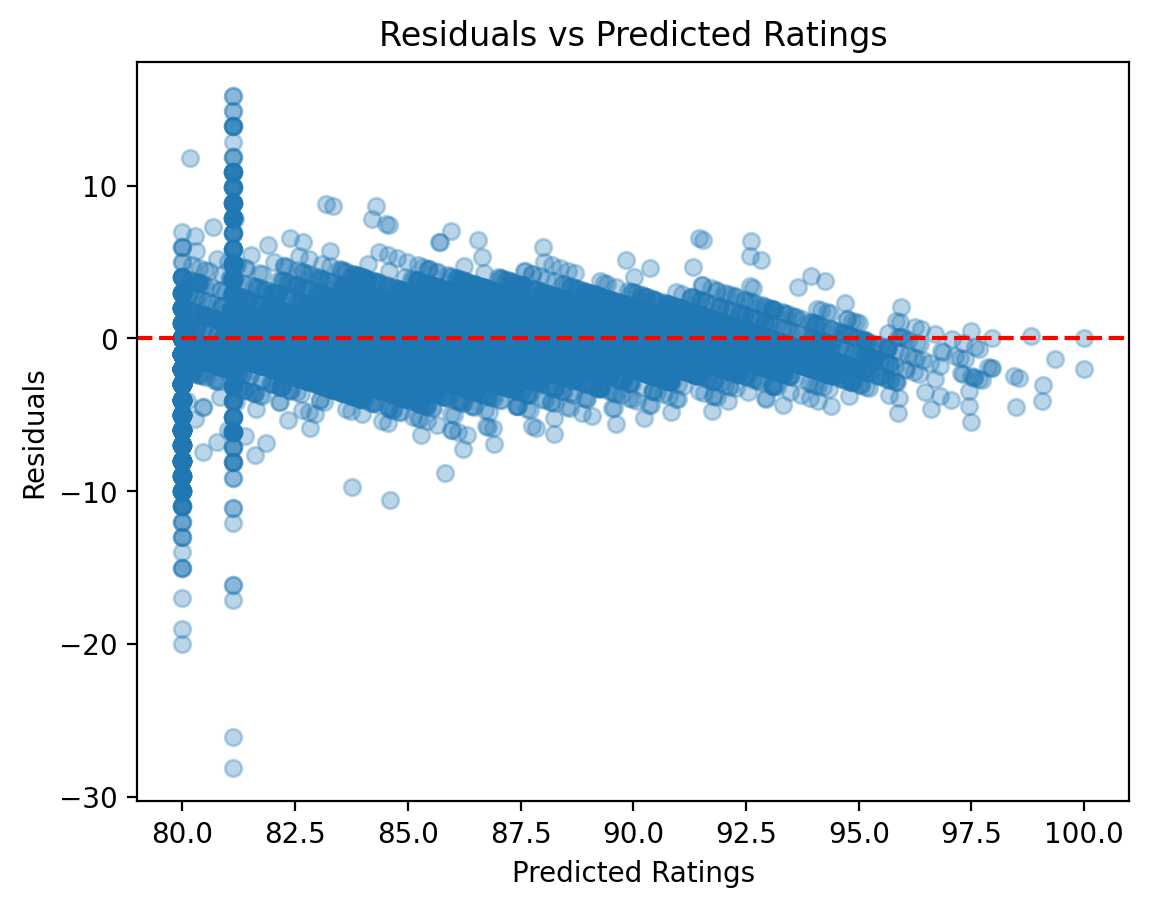

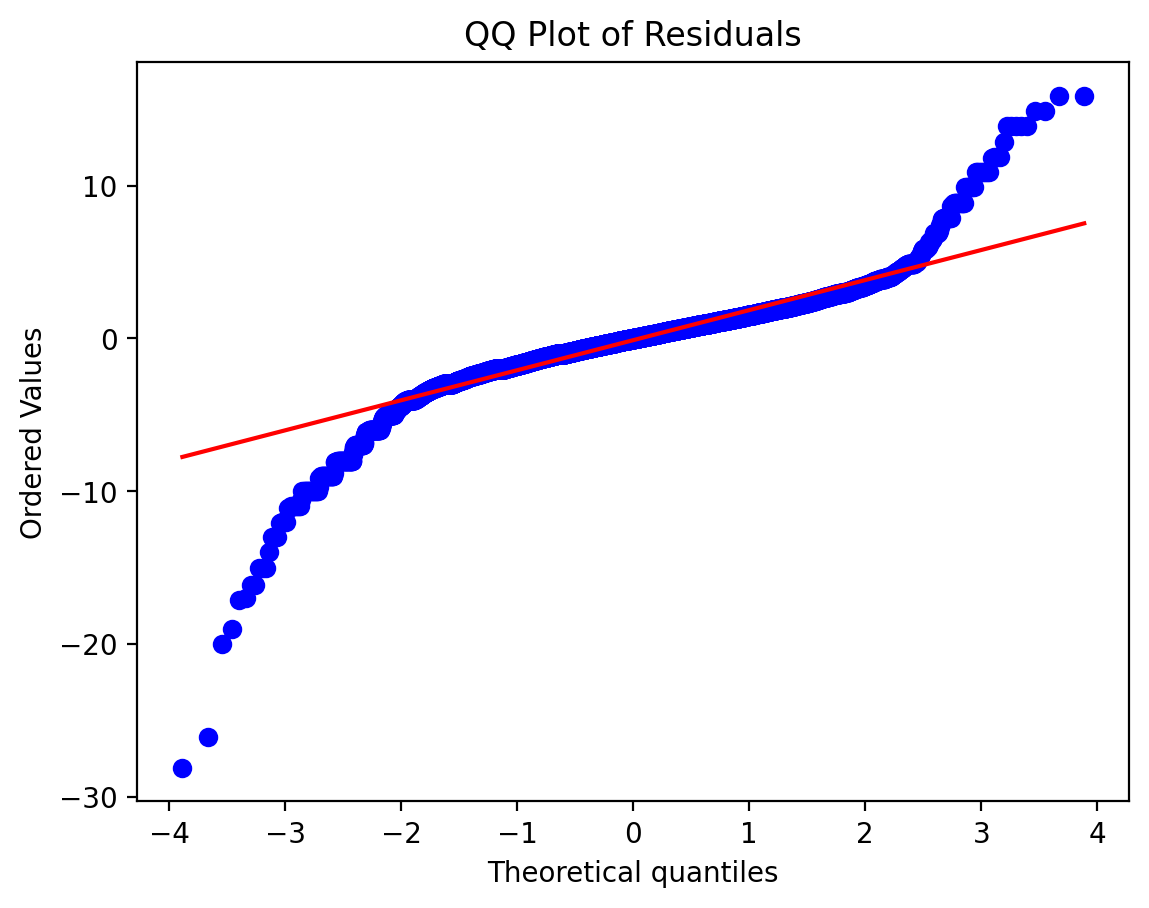

In [ ]:
import matplotlib.pyplot as plt
import scipy.stats as stats

df_cleaned["residuals"] = df_cleaned["rating"] - df_cleaned["predicted_rating_2"]
# Residual vs Predicted
plt.figure()
plt.scatter(df_cleaned["predicted_rating_2"], df_cleaned["residuals"], alpha=0.3)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted Ratings")
plt.ylabel("Residuals")
plt.title("Residuals vs Predicted Ratings")
plt.show()

# QQ plot
plt.figure()
stats.probplot(df_cleaned["residuals"], dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

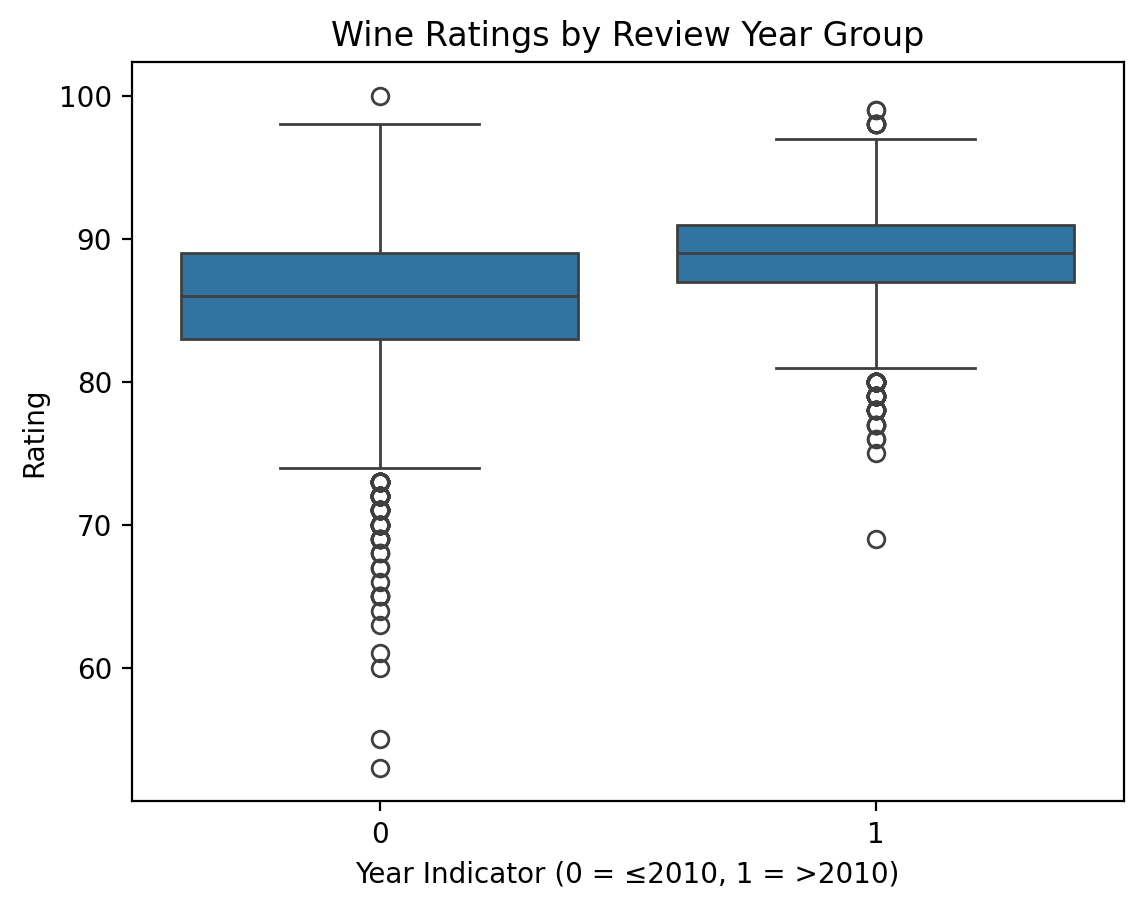

In [ ]:
import seaborn as sns

plt.figure()
sns.boxplot(x="year_indicator", y="rating", data=df_cleaned)
plt.title("Wine Ratings by Review Year Group")
plt.xlabel("Year Indicator (0 = ≤2010, 1 = >2010)")
plt.ylabel("Rating")
plt.show()

# Task
Visualize the relationship between 'rating' and 'clean_year' for different bins of 'sentiment' using scatter plots.

## Bin sentiment

### Subtask:
Create discrete bins for the 'sentiment' column based on specified intervals.


**Reasoning**:
Create discrete bins for the 'sentiment' column using pd.cut and inspect the distribution of the new column.



In [ ]:
# Define bin edges for sentiment
sentiment_bins = [df_cleaned['sentiment'].min(), 0.5, 1.0, 1.5, 2.0, df_cleaned['sentiment'].max()]

# Create a new categorical column based on sentiment bins
df_cleaned['sentiment_bin'] = pd.cut(df_cleaned['sentiment'], bins=sentiment_bins, include_lowest=True, labels=False)

# Inspect the distribution of data within the new sentiment_bin column
print(df_cleaned['sentiment_bin'].value_counts().sort_index())
df_cleaned.head()

sentiment_bin
0    1768
1    4913
2    5670
3    1276
4      69
Name: count, dtype: int64


,index,true_rating,predicted_rating,sentiment,rating,Clean_desc,review_year,clean_year,year_indicator,predicted_rating_2,residuals,sentiment_bin
0,13343,88.0,86.771576,0.937251,88,"Light and soft, with cherry and raspberry flav...",NV (reviewed 2019),2019,1,86.892815,1.107185,1
1,4793,92.0,92.506035,1.662355,92,This creamy Champagne has a round juiciness to...,NV (reviewed 2023),2023,1,92.836973,-0.836973,3
2,13811,91.0,90.806600,1.413998,91,"Warm fruitcake, brown bread and mulled raisin ...",NV (reviewed 2017),2017,1,90.801026,0.198974,2
3,11029,90.0,90.160310,1.328816,90,"A spiced rosé, with a Lambic-like hint of mace...",NV (reviewed 2014),2014,1,90.102730,-0.102730,2
4,7355,93.0,89.342350,1.226706,93,"Flattering and stylish, with baked peach, quin...",NV (reviewed 2021),2021,1,89.265664,3.734336,2


## Group and plot

### Subtask:
For each sentiment bin, create a scatter plot showing the relationship between 'rating' (on the y-axis) and 'clean_year' (on the x-axis).


**Reasoning**:
Iterate through each unique sentiment bin and create a scatter plot of rating vs year for each bin.



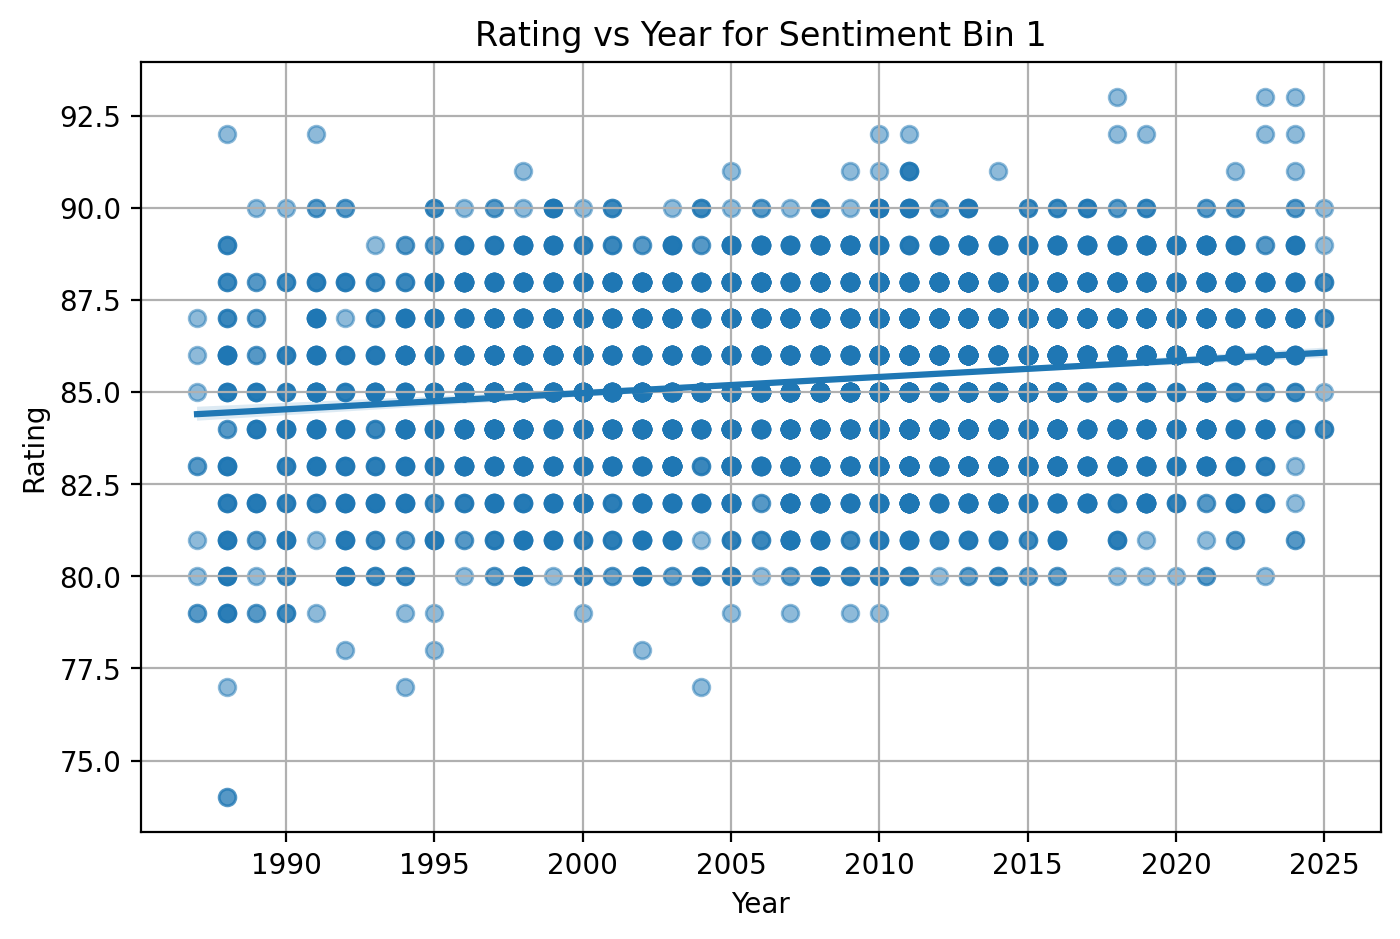

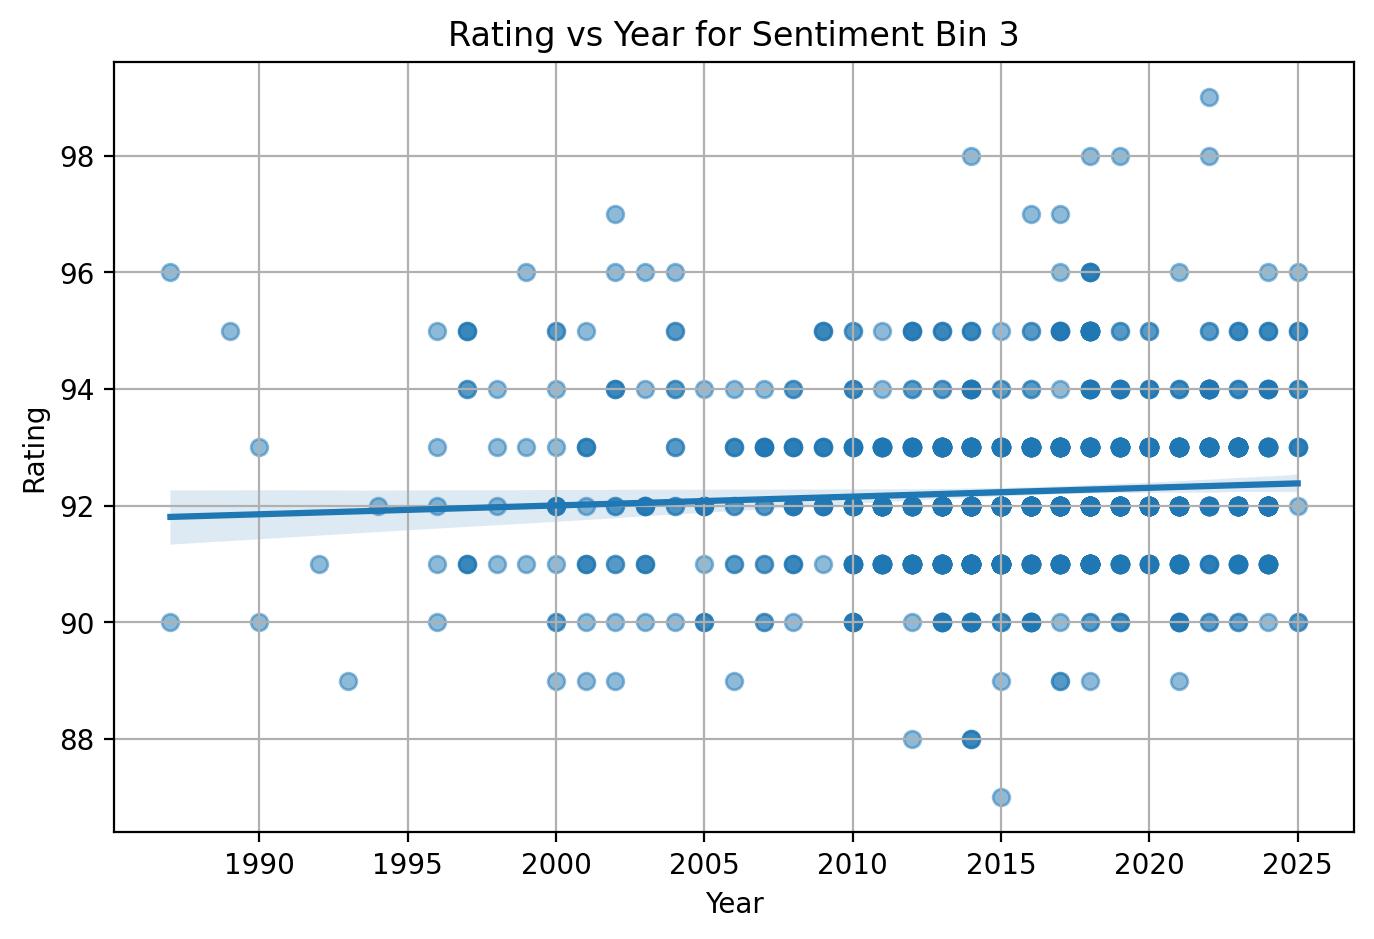

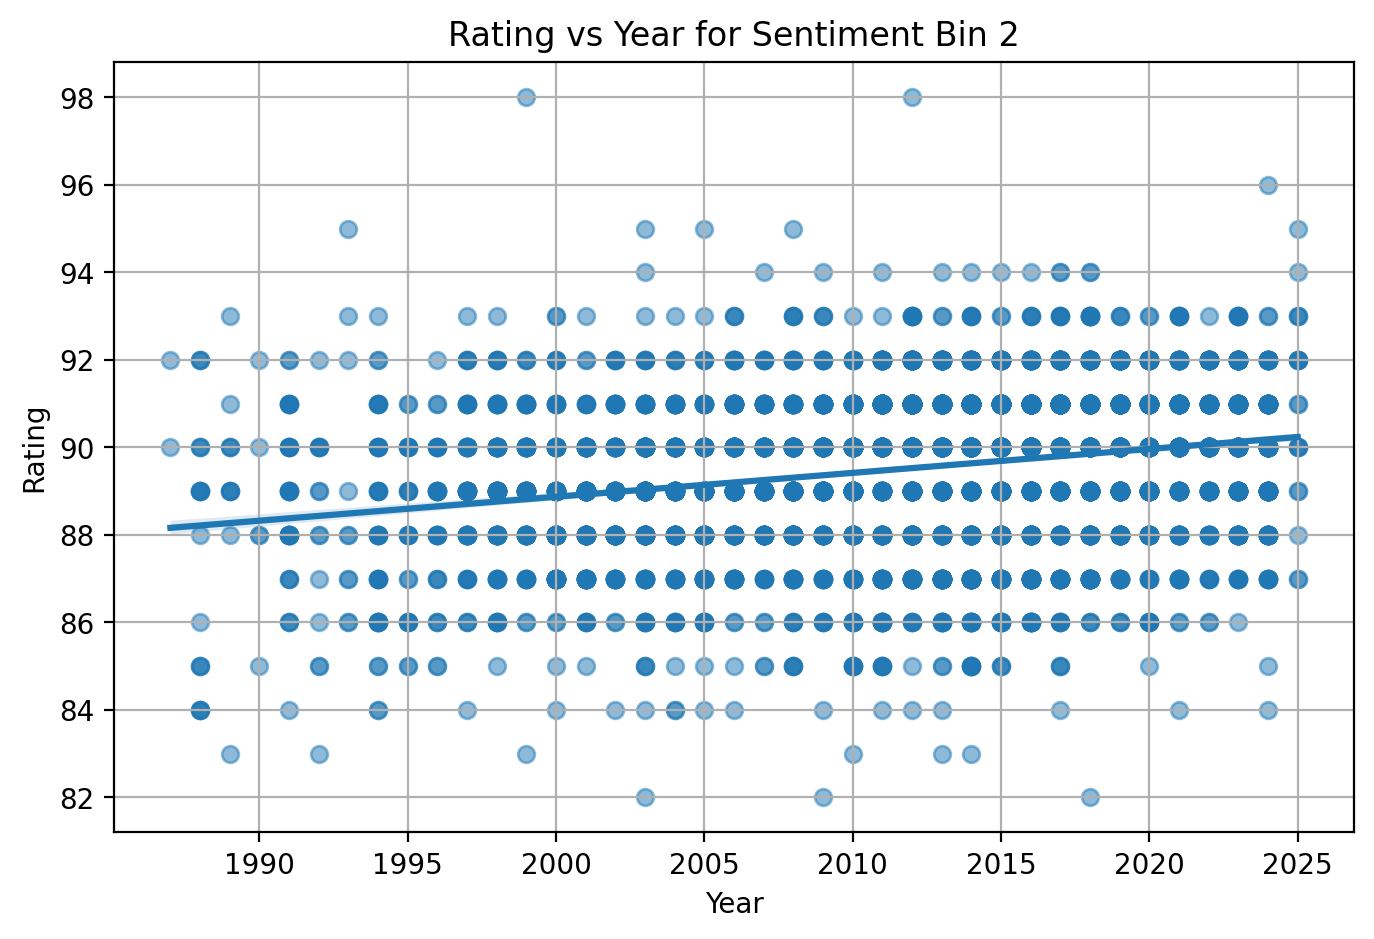

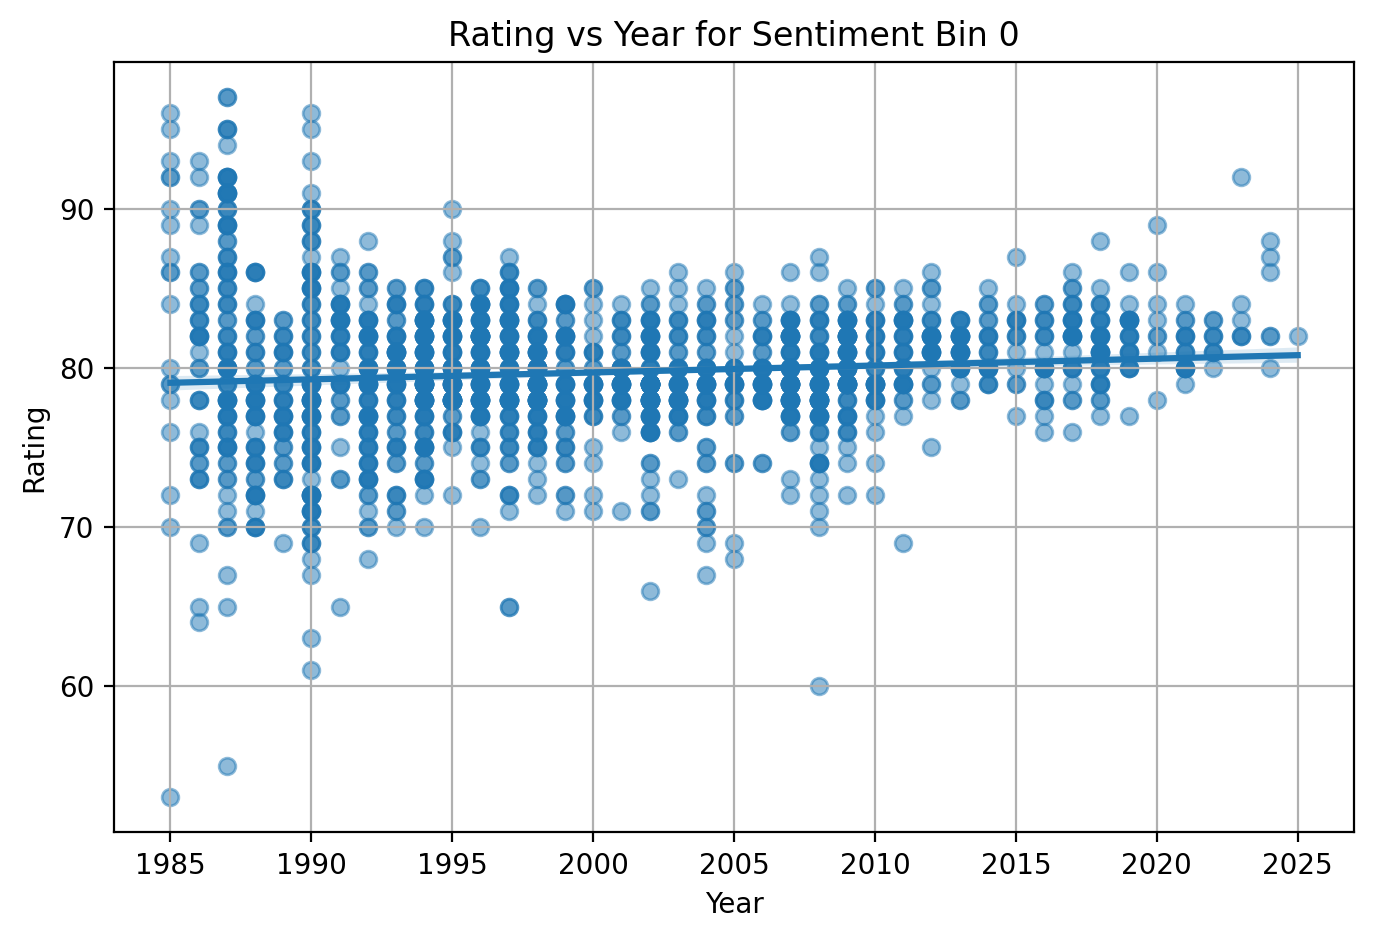

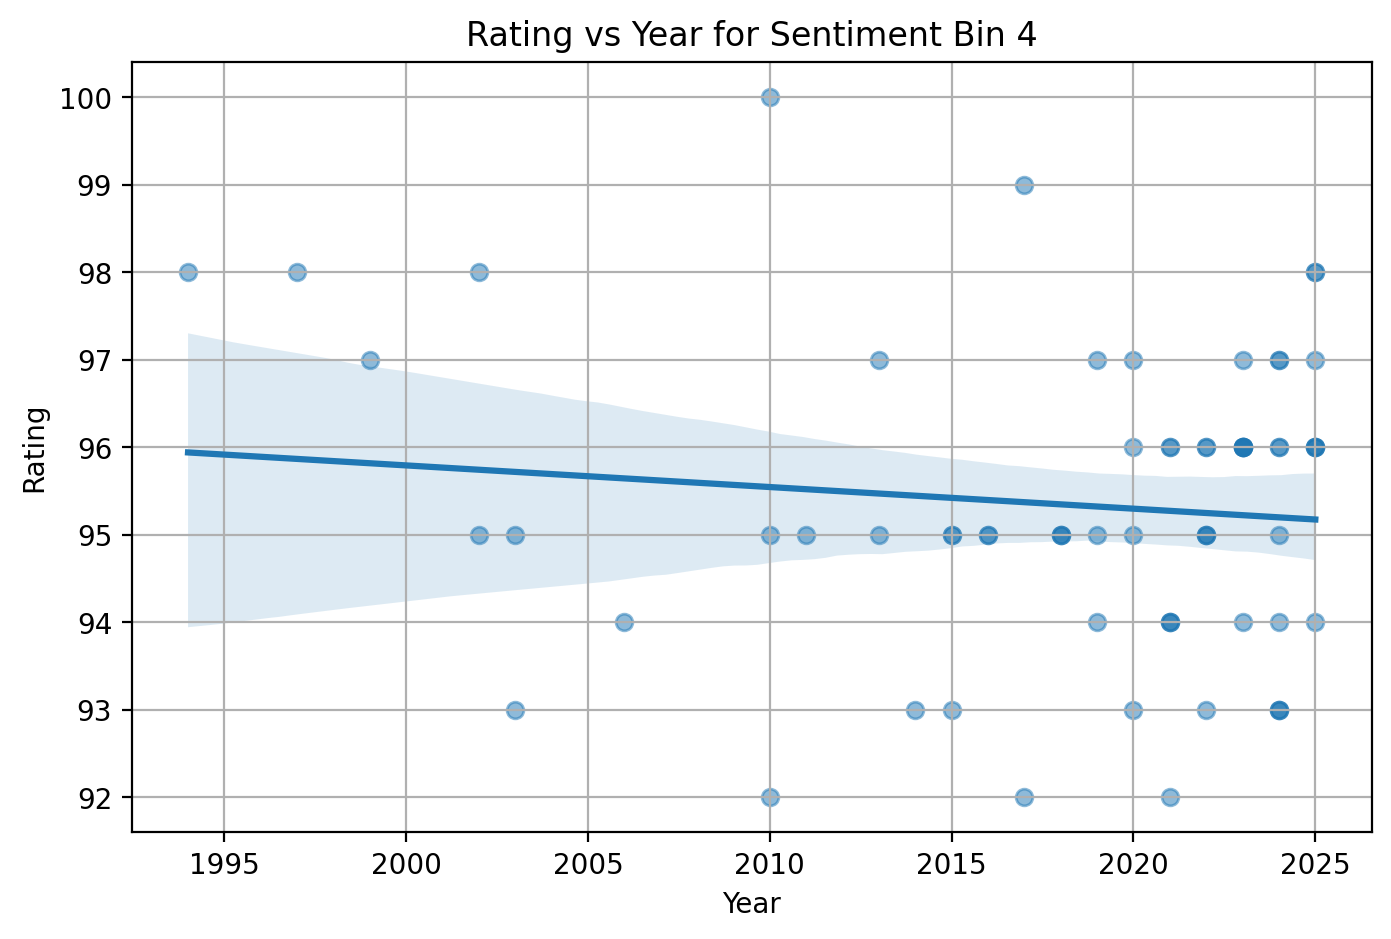

In [ ]:
# Iterate through each unique sentiment bin
for bin_value in df_cleaned['sentiment_bin'].unique():
    # Filter the DataFrame for the current sentiment bin
    df_bin = df_cleaned[df_cleaned['sentiment_bin'] == bin_value]

    # Create a scatter plot with a regression line for the filtered data
    plt.figure(figsize=(8, 5))
    sns.regplot(data=df_bin, x='clean_year', y='rating', scatter_kws={'alpha':0.5})
    plt.title(f'Rating vs Year for Sentiment Bin {bin_value}')
    plt.xlabel('Year')
    plt.ylabel('Rating')
    plt.grid(True)
    plt.show()

## Summary:

### Data Analysis Key Findings

*   The 'sentiment' column was successfully binned into five discrete categories based on specified intervals.
*   Scatter plots were generated for each sentiment bin, visualizing the relationship between 'rating' and 'clean\_year'.

### Insights or Next Steps

*   Analyze the generated scatter plots to identify any discernible trends or patterns in the relationship between rating and year within different sentiment ranges.
*   Consider adding regression lines to the scatter plots to better illustrate potential trends.
